# Peak fitting example

Charles Le Losq, May 2017; Updated January 2024, April 2025

In the new version, we showcase the use of the `fit_peaks` function and then show also how you can solve the problem with Turing.jl and JuMP too. Running the notebook entirely thus requires you to have those installed, but if you want to stop at the `fit_peaks` function, you can skip the cells related to Turing.jl and JuMP!

## Generating data

We generate three peaks using Spectra's functions:

In [1]:
using Revise
# using Spectra and Plots for plotting and peak fitting

[ Info: Precompiling Spectra [391af1a9-06f1-59d3-8d21-0be089654739] (cache misses: include_dependency fsize change (2), wrong dep version loaded (6), mismatched flags (8))


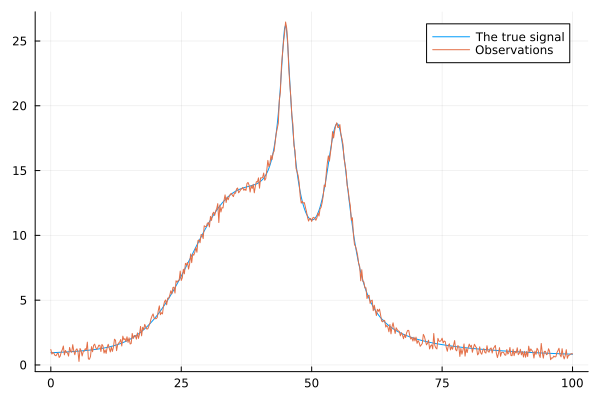

The estimated mean standard error on y_obs is 0.26


In [2]:
using Plots, Spectra, StatsBase

## The X axis
x = collect(0:0.2:100)
## The "perfect" Y signal
y_perfect = (
    gaussian(x, [10.0, 35.0, 10.0]) +
    lorentzian(x, [15.0, 55.0, 3.0]) +
    pearson7(x, [20.0, 45.0, 2.0, 0.4])
)
## Of course, in real world we have noise, here it is Gaussian
noise = randn(length(x))*0.3

## This is what we observe and want to fit
y_obs = y_perfect + noise

## Let's visualize it!
p1 = plot(x, [y_perfect, y_obs]; labels=["The true signal" "Observations"])
display(p1)
##savefig("fit_1.svg"); nothing #hide
# ![](fit_1.svg)

# ## Declaring peak informations
#
# In the real world, we see only the above figure. 
# We guess peak positions and shapes based on the visual inspection. 
# So we start with prior estimates on peak parameters based on this visual inspection. 
# Data from publications can bring further insights. This helps e.g. constraining the position of 
# some peaks, and `Spectra.fit_peaks` leverages such information via an *à priori* vector of 
# peak parameter uncertainties (1-sigma).
# 
# Another option is available : you can place lower and upper bounds on parameter values. 
# This is very useful if your parameters cannot take some values: e.g. hwhm should be positive 
# and lorentzian_fraction should be comprised between 0 and 1.
# 
# All this is indicated as follow:

peaks_info = [
    ## (peak_type, initial_params, params_uncertainties, lower_bounds, upper_bounds)
    (   
        :gaussian, ## peak_type
        [10.5, 30.0, 11.0], ## initial_params > prior model
        [5.0, 5.0, 3.0], ## params_uncertainties  > prior model uncertainties
        [0.0, 0.0, 0.0], ## lower_bounds
        [Inf, Inf, 50.0]), ## upper_bounds
    (
        :lorentzian, ## peak_type
        [17.5, 54.0, 3.1], ## initial_params > prior model
        [5.0, 3.0, 1.0], ## params_uncertainties > prior model uncertainties
        [0.0, 0.0, 0.0], ## lower_bounds
        [Inf, Inf, Inf], ## upper_bounds
    ),
    (
        :pearson7, ## peak_type
        [21.5, 44.0, 3.0, 0.4], ## initial_params > prior model
        [3.0, 2.0, 5.0, 0.02], ## params_uncertainties > prior model uncertainties
        [0.0, 0.0, 0.0, 0.0], ## lower_bounds
        [100.0, 100.0, 50.0, Inf], ## upper_bounds
    ),
]

# ## Error on the data?
#
# Usually we also do not have a precise idea of the errors that affect y. A good approximation 
# can be to simply smooth the signal, and calculate the errors using the smoothed signal and the observed one.
# Let's also do that here and check that it yields a fairly good approximation of the true error (should be around 0.3)

y_smo = smooth(x, y_obs, method="gcvspline");
estimated_mean_error = sqrt(mean((y_obs .- y_smo).^2))
println("The estimated mean standard error on y_obs is $(round(estimated_mean_error,digits=2))")

# OK, the result seems to be not too bad. We will place ourselves in a "real world" situation and 
# use those errors. For convenience we create an vector of errors

estimated_error = estimated_mean_error * ones(size(x));

# ## Fitting
#
# We use now the `fit_peaks` function to perform the fit.
# 
# This function returns a Named Tuple with various fields (see documentation).
# 
# First, we need to create the Julia object that contains all the context of the fit, 
# including the data, priors, peak informations...

ctx = prepare_context(x, peaks_info, estimated_error)

# We launch the fit using the quasi-Newton algorithm implemented in Spectra. 
# This algorithm assumes that everything is Gaussian: the distributions
# of parameter and data errors are assumed to be Gaussian, and we also
# assume that the problem is nearly linear near the optimal point. In practice, 
# this algorithm works well and has the advantage of leveraging the prior information provided
# in `peaks_info`.
# The downside is sometimes some numerical instability: when `relax`is too low, DomainError is raised because 
# complex numbers appear in the Hessian matrix and mess with the sqrt() function. The fit is thus not good.
# In this case, increase relax to make smaller optimization steps, and also 
# maxiter to allow more iterations for convergence.

result = fit_peaks(ctx, y_obs, backend=:qGN, relax=5)

## we print the result using
print_params(result.peak_results, digits=3)

## and we plot the fit
plot_fit(ctx, result.fitted_params, y_obs; components=true)
##savefig("fit_2.svg"); nothing #hide
# ![](fit_2.svg)

# You could also use the Optim backend, which, in addition to the  leverages the lower and upper boundaries 
# declared earlier in `peaks_info`: 

result = fit_peaks(ctx, y_obs, backend=:Optim)
print_params(result.peak_results, digits=3)
plot_fit(ctx, result.fitted_params, y_obs; components=true)
##savefig("fit_3.svg"); nothing #hide
# ![](fit_3.svg)

# We also have access to the peak areas via `result.peak_areas`:

#println(result.areas)

# ## Checking errors with bootstrapping
# The errors provided above come from the Hessian matrix at the optimal point.
# Those may not always be the good ones, if the loss function cannot be linearized close to the minimum.
# In fact, in my experience, in most cases those are not realistic estimates of parameter uncertanties
# in peak fitting problems.
#
# To check for parameter errors, one option is to use bootstrapping.
# [`bootstrap`](@ref) allows to bootstrap your spectrum and refit the model on data subsamples.
# The interface is easy, similar to that of `fit_peaks` but the context is defined internally so 
# you don't even have to worry about that. Let's try it:

boot_params = bootstrap(x, y_obs, estimated_error, peaks_info, nb_boot = 10, backend=:qGN, relax=5., maxiter=100)

# We pass the array of bootstrapped parameters to the `get_peak_results` function that prepare 
# a nice vector of peak results that we can use for plotting and printing:
#
boot_results = get_peak_results(ctx, StatsBase.mean(boot_params, dims=2), StatsBase.std(boot_params, dims=2))

# We can now print the bootstrapped results and compare the errors with those
# previously calculated from the Hessian:
print_params(boot_results, digits=3)

# OK, actually for this example, we see that the errors from the boostrap analysis
# are close to those calculated from the Hessian matrix. Everything thus seems OK.
#
# Of course, a final quick visual inspection is always nice. This can be done by passing the 
# median of the matrix of bootstrapped parameters to the plot_fit function
plot_fit(ctx, StatsBase.median(boot_params, dims=2), y_obs, components=true)
##savefig("fit_4.svg"); nothing #hide
# ![](fit_4.svg)


Peak 1 (gaussian):
  amplitude: 10.024 ± 0.054
  center: 35.158 ± 0.089
  width: 10.233 ± 0.089
Peak 2 (lorentzian):
  amplitude: 14.992 ± 0.08
  center: 55.032 ± 0.017
  width: 3.007 ± 0.027
Peak 3 (pearson7):
  amplitude: 19.753 ± 0.148
  center: 45.008 ± 0.01
  width: 1.953 ± 0.037
  exponent: 0.4 ± 0.004
Peak 1 (gaussian):
  amplitude: 10.024 ± 0.054
  center: 35.158 ± 0.088
  width: 10.233 ± 0.089
Peak 2 (lorentzian):
  amplitude: 14.992 ± 0.08
  center: 55.032 ± 0.017
  width: 3.007 ± 0.027
Peak 3 (pearson7):
  amplitude: 19.753 ± 0.148
  center: 45.008 ± 0.01
  width: 1.953 ± 0.037
  exponent: 0.4 ± 0.004
Peak 1 (gaussian):
  amplitude: 10.001 ± 0.08
  center: 35.148 ± 0.113
  width: 10.254 ± 0.099
Peak 2 (lorentzian):
  amplitude: 14.969 ± 0.054
  center: 55.034 ± 0.015
  width: 2.999 ± 0.029
Peak 3 (pearson7):
  amplitude: 19.733 ± 0.114
  center: 45.006 ± 0.011
  width: 1.97 ± 0.057
  exponent: 0.402 ± 0.004


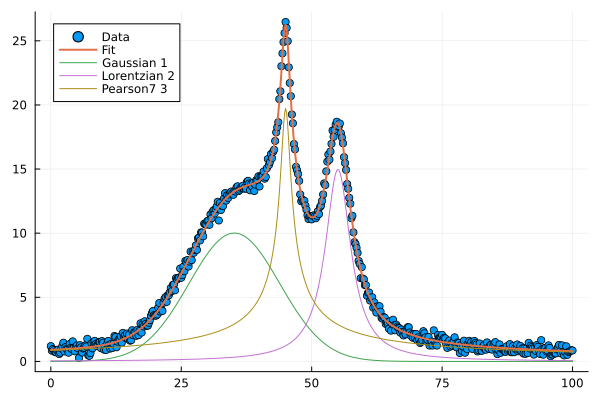

In [87]:
ctx.peak_functions

Dict{Symbol, Function} with 4 entries:
  :pearson7    => pearson7
  :lorentzian  => lorentzian
  :gaussian    => gaussian
  :pseudovoigt => pseudovoigt

In [17]:
using Turing 

@model function fit_peaks_model(x, y, peaks_info, σ_noise=0.1)
    # Precompute total number of parameters
    total_params = sum(p -> p[1] == :pseudovoigt ? 4 : 3, peaks_info)
    
    # Define all parameters in a single vector with proper scoping
    params = Vector{Real}(undef, total_params)
    current_idx = 1
    
    for (i, (peak_type, init_params, uncertainties)) in enumerate(peaks_info)
        n_params = peak_type == :pseudovoigt ? 4 : 3
        
        # Define priors for each parameter in this peak
        for j in 1:n_params
            params[current_idx] ~ Normal(init_params[j], uncertainties[j])
            current_idx += 1
        end
    end
    
    # Define observation noise
    σ ~ truncated(Normal(σ_noise, 0.05), 0.0, Inf)
    
    # Rebuild the parameter list for model calculation
    current_idx = 1
    y_pred = zero(x) .* zero(eltype(params))
    
    for (i, (peak_type, _, _)) in enumerate(peaks_info)
        n_params = peak_type == :pseudovoigt ? 4 : 3
        p = params[current_idx:(current_idx + n_params - 1)]
        
        if peak_type == :gaussian
            y_pred .+= gaussian(x, p)
        elseif peak_type == :lorentzian
            y_pred .+= lorentzian(x, p)
        elseif peak_type == :pseudovoigt
            y_pred .+= pseudovoigt(x, p)
        end
        
        current_idx += n_params
    end
    
    # Likelihood
    y ~ MvNormal(y_pred, σ^2 * I)
end

fit_peaks_model (generic function with 4 methods)

In [18]:
chain = sample(fit_peaks_model(x_fit, y_fit, peaks_info), NUTS(), 2000, nchains=3, progress=true)


LoadError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{DynamicPPL.DynamicPPLTag, Float64}, Float64, 11})
The type `Float64` exists, but no method is defined for this combination of argument types when trying to construct it.

[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat
[0m[90m   @[39m [90mBase[39m [90m[4mrounding.jl:265[24m[39m
[0m  (::Type{T})(::T) where T<:Number
[0m[90m   @[39m [90mCore[39m [90m[4mboot.jl:900[24m[39m
[0m  Float64([91m::IrrationalConstants.Twoinvπ[39m)
[0m[90m   @[39m [33mIrrationalConstants[39m [90m~/.julia/packages/IrrationalConstants/lWTip/src/[39m[90m[4mmacro.jl:131[24m[39m
[0m  ...


In [32]:
# for Bayesian peak fitting example
using Turing

# Define a Bayesian model with priors
@model function bayesian_peaks(x, y)
    # Define priors based on peak_types
    # PEAK 3
    amplitude3 ~ truncated(Normal(25.5, 0.5), 0.0, Inf)
    center3 ~ Normal(43.0, 10.0)
    width3 ~ truncated(Normal(2.0, 0.5), 0.0, Inf)
    lr ~ truncated(Normal(0.39, 0.03), 0.0, 1.0)
    
    # Calculate model prediction
    μ3 = pseudovoigt(x, [amplitude3, center3, width3, lr])
    
    # Likelihood
    σ ~ truncated(Normal(0.2, 0.03), 0.001, Inf)
    y ~ MvNormal(μ3, σ^2 * I)
end

chain = sample(bayesian_peaks(x_fit, y_fit), NUTS(), 2000, nchains=3, progress=true)

┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (2000×17×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 4.85 seconds
Compute duration  = 4.85 seconds
parameters        = amplitude3, center3, width3, lr, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

  amplitude3   20.6906    0.1515    0.0035   1941.4248   1363.8987    1.0001   ⋯
     center3   44.9674    0.0353    0.0007   2215.8764   1545.1224    1.0012   ⋯
      width3    4.8775    0.0546    0.0013   1836.4466   1229.1803    0.9999   ⋯
          lr    0.3776    0.0227    0.0005   2036.6295   1266.9847    1.0007   ⋯
           σ    0.6922    0.0135    0.0

In [45]:
chain.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 1001:1:3000
    :var, [:amplitude3, :center3, :width3, :lr, :σ, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 2000×17×1 Array{Float64, 3}:
[:, :, 1] =
 20.8079  45.0105  4.82335  0.39023   …  3.0  0.0  0.626083  0.626083
 20.666   44.9822  4.84135  0.367789     2.0  0.0  0.626083  0.626083
 20.5833  44.9373  4.95447  0.353964     3.0  0.0  0.626083  0.626083
 20.5702  44.9498  4.85436  0.37701      2.0  0.0  0.626083  0.626083
 20.4195  44.9956  4.99349  0.375595     3.0  0.0  0.626083  0.626083
 20.5675  45.0109  4.95652  0.383261  …  3.0  0.0  0.626083  0.626083
 20.7544  44.9553  4.91427  0.397122     1.0  0.0  0.626083  0.626083
 20.4209  44.9369  4.93695  0.380244     2.0  0.0  0.626083  0.626083
 20.6596  44.975   4.85426  0.404833     3.0  0.0

## Checking errors with bootstrapping

`Spectra.bootsample` allows to bootstrap your spectrum and refit the model on data subsamples. This allows to check the errors on parameters!

Let's do that for the first peak:

In [175]:
peaks_info = [
# (type, initial_params, uncertainties, lower_bounds, upper_bounds)
(:gaussian, [10.5, 30.0, 3.0], [5.0, 10.0, 5.0], [0., 25., 0.], [Inf, Inf, 50.]),
(:lorentzian, [20.5, 55.0, 3.0], [10.0, 10., 5.0], [0., 50., 0.], [100., 100., 50.]),
(:pseudovoigt, [20.5, 44.0, 3.0, 0.4], [5.0, 5., 5.0, 0.1], [0., 0., 0., 0.], [100., 100., 50., 1.])
]

result = fit_peaks(x_fit, y_fit, peaks_info, sigma=noise, backend=:qGN, relax=5, maxiter=100)
result.print_params()

Peak 1 (gaussian):
  amplitude: 10.0065 ± 0.0103
  center: 35.0051 ± 0.0168
  width: 9.9888 ± 0.0147
Peak 2 (lorentzian):
  amplitude: 14.9883 ± 0.0087
  center: 54.9985 ± 0.0028
  width: 3.0048 ± 0.0049
Peak 3 (pseudovoigt):
  amplitude: 19.9187 ± 0.0593
  center: 45.0034 ± 0.0026
  width: 2.0038 ± 0.0033
  fraction: 0.3955 ± 0.0105


In [211]:
boot_params = zeros((length(result.fitted_params), 20))
for i = 1:20
    x_boot, y_boot = bootsample(x_fit, y_fit)
    # Define peak information with initial parameters and uncertainties
    noise = 0.3*ones(size(x_boot,1)) 
    # Perform the fit
    local result = fit_peaks(vec(x_boot), vec(y_boot), peaks_info, sigma=noise, backend=:qGN, relax=5., maxiter=100)
    boot_params[:,i] = result.fitted_params
    print(i)
end



1234567891011121314151617181920

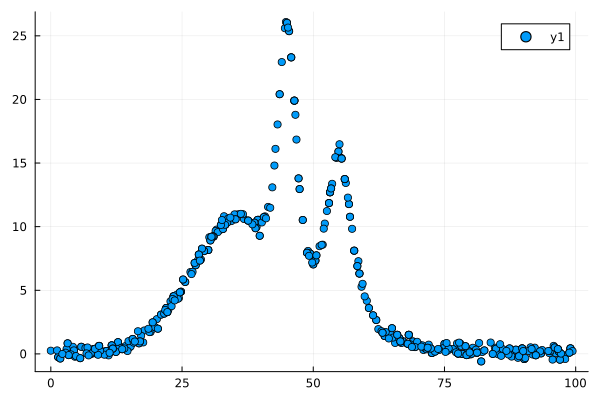

In [212]:
x_boot, y_boot = bootsample(x_fit, y_fit)
scatter(x_boot, y_boot)

In [208]:
boot_params

10×200 Matrix{Float64}:
 10.1716     9.95906   10.1221    …  10.1223    10.084     10.0312
 35.2518    34.9521    35.2949       35.1842    35.1297    35.3012
 10.097      9.96614   10.254        10.0714    10.0914    10.2524
 14.9905    14.9657    14.9272       15.0066    14.8989    14.7562
 55.0044    54.9605    54.9719       54.979     54.9589    54.9836
  3.03017    3.06167    3.05435   …   3.00721    3.01498    3.05136
 19.6312    19.925     19.4976       19.6884    19.6237    19.4236
 45.0129    45.0216    45.0258       45.0275    45.0176    44.9913
  1.94534    1.97445    1.95232       1.95222    1.96874    1.95303
  0.322126   0.353445   0.294838      0.354824   0.364687   0.348363

In [209]:
import Statistics
println(Statistics.std(boot_params; dims=2)[:,1])

[0.05985859833589455, 0.12714918338527806, 0.11439417989746482, 0.09563718456425759, 0.021499615266280487, 0.03774285374632306, 0.19111416763196395, 0.009363048114612294, 0.016764548289042093, 0.038465895221641316]


In [213]:
import Statistics
println(Statistics.std(boot_params; dims=2)[:,1])

[0.06626014720240873, 0.15050413180338976, 0.12024131450019994, 0.08444436016995624, 0.015957591157310762, 0.03553253505422436, 0.20994102404120982, 0.010822889045780965, 0.019201070208922526, 0.04943514485753099]


## Exploring errors on parameters Using Turing.jl

The same problem can be tackled using Turing.jl and the peak shape functions from Spectra as follow. This offers another way to check that the estimated errors are good for instance.

It seems to run well but it is not fully optimized. If you have suggestions, do not hesitate!


In [57]:
# for Bayesian peak fitting example
using Turing

# Define a Bayesian model with priors
@model function bayesian_peaks(x, y)
    # Define priors based on peak_types
    # Example for a Gaussian peak
    amplitude ~ truncated(Normal(10.016, 0.5), 0.0, Inf)
    center ~ Normal(34.92, 0.5)
    width ~ truncated(Normal(10.0, 0.5), 0.0, Inf)

    μ = gaussian(x, [amplitude, center, width])
    
    # PEAK 2
    amplitude2 ~ truncated(Normal(14.9, 0.5), 0.0, Inf)
    center2 ~ Normal(55.0, 0.5)
    width2 ~ truncated(Normal(3.0, 0.5), 0.0, Inf)
    
    μ2 = lorentzian(x, [amplitude2, center2, width2])
    
    # PEAK 3
    amplitude3 ~ truncated(Normal(25.5, 0.5), 0.0, Inf)
    center3 ~ Normal(43.0, 10.0)
    width3 ~ truncated(Normal(2.0, 0.5), 0.0, Inf)
    lr ~ truncated(Normal(0.39, 0.03), 0.0, 1.0)
    
    # Calculate model prediction
    μ3 = pseudovoigt(x, [amplitude3, center3, width3, lr])
    
    # Likelihood
    σ ~ truncated(Normal(0.2, 0.03), 0.001, Inf)
    y ~ MvNormal(μ + μ2 + μ3, σ^2 * I)
end

chain = sample(bayesian_peaks(x_fit, y_fit), NUTS(), 2000, nchains=3, progress=true)

┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:25


Chains MCMC chain (2000×23×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 104.76 seconds
Compute duration  = 104.76 seconds
parameters        = amplitude, center, width, amplitude2, center2, width2, amplitude3, center3, width3, lr, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

   amplitude   14.7006    0.1509    0.0032   2200.3091   1551.2884    1.0009   ⋯
      center   41.1993    0.1544    0.0039   1556.9532   1196.3887    1.0014   ⋯
       width   12.0608    0.1749    0.0043   1632.4618   1193.9049    1.0000   ⋯
  amplitude2   12.6392    0.3452    0.0082   1799.1047   1292